# Importing Libraries Here

In [1]:
import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import time
import os
from pandas_profiling import ProfileReport
from skimage import io
import skimage
from itertools import product
import random
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18, densenet121, mobilenet_v2
from albumentations import RandomRotate90, Flip, Compose, Normalize, RandomResizedCrop
from sklearn.model_selection import train_test_split
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler, Adam, SGD
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

Using TensorFlow backend.


device(type='cuda')

# Reading All Files

In [2]:
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
# #         print(os.path.join(dirname, filename))

# Path Variables

In [3]:
BASE_PATH='../input/prostate-cancer-grade-assessment/'
TRAIN_IMAGES_PATH = BASE_PATH + 'train_images/'
TRAIN_LABELS_PATH = BASE_PATH + 'train_label_masks/'
TEST_IMAGES_PATH = BASE_PATH+'test_images'
SAMPLE = BASE_PATH+'sample_submission.csv'
TRAIN=BASE_PATH+'train.csv'
TEST = BASE_PATH+'test.csv'

train_df = pd.read_csv(TRAIN)
train = train_df.copy()
test_df = pd.read_csv(TEST)
test = test_df.copy()

# Data Anaysis

In [4]:
train['isup_grade'].unique()
train.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [5]:
train_image = os.listdir(TRAIN_IMAGES_PATH)
train_label = os.listdir(TRAIN_LABELS_PATH)
print("length of training images", len(train_image))
print("length of training labels", len(train_label))

length of training images 10616
length of training labels 10516


In [6]:
trimmed_train_image=[]
for img in train_image:
    trimmed_train_image.append(img.split('.tiff')[0])
    
trimmed_train_label=[]

for img in train_label:
    trimmed_train_label.append(img.split('_mask.tiff')[0])

## Number of missing mask images

In [7]:
missing_img = np.setdiff1d(trimmed_train_image, trimmed_train_label)
print(missing_img.shape)

(100,)


In [8]:
print(len(trimmed_train_image))
print(len(trimmed_train_label))

masks=os.listdir(BASE_PATH+'train_label_masks/')
images=os.listdir(BASE_PATH+'train_images/')


10616
10516


In [9]:
df_masks=pd.Series(masks).to_frame()
df_masks.columns=['mask_file_name']
df_masks['image_id']=df_masks.mask_file_name.apply(lambda x:x.split('_')[0])
# df_masks

In [10]:
df_train=pd.merge(train,df_masks,on='image_id',how='outer')
del df_masks
# df_train.head()

## Processing gleason score column with 'negative' entries

In [11]:
gleason_replace_dict = {0:0, 1:1, 3:2, 4:3, 5:4}

def process_gleason(gleason):
    if gleason == 'negative': gs = (1, 1)
    else: gs = tuple(gleason.split('+'))
    return [gleason_replace_dict[int(g)] for g in gs]

df_train.gleason_score = df_train.gleason_score.apply(process_gleason)

In [12]:
# df_train.head()

In [13]:
df_train['gleason_primary'] = ''
df_train['gleason_secondary'] = ''

for idx in range(0, len(df_train.gleason_score)):
    df_train['gleason_primary'][idx] = df_train['gleason_score'][idx][0]
    df_train['gleason_secondary'][idx] = df_train['gleason_score'][idx][1]
    
df_train = df_train.drop(['gleason_score'], axis=1)
# df_train.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Removing All Empty Masks

In [14]:
df_train['mask_file_name'].isnull().sum()

100

In [15]:
df_train.dropna(subset=['mask_file_name'], inplace=True, axis=0)

In [16]:
df_train.head()

,image_id,data_provider,isup_grade,mask_file_name,gleason_primary,gleason_secondary
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0005f7aaab2800f6170c399693a96917_mask.tiff,0,0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,000920ad0b612851f8e01bcc880d9b3d_mask.tiff,0,0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,0018ae58b01bdadc8e347995b69f99aa_mask.tiff,3,3
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,001c62abd11fa4b57bf7a6c603a11bb9_mask.tiff,3,3
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,001d865e65ef5d2579c190a0e0350d8f_mask.tiff,0,0


# Panda Data Report

In [17]:
# profile = ProfileReport(df_train, title="Prostate Cancer Data")
# profile.to_file("report.html")

# Tile Method to speed up computation

In [18]:
def tile(img, sz=128, N=16):
    shape = img.shape
    pad0,pad1 = (sz - shape[0]%sz)%sz, (sz - shape[1]%sz)%sz
    img = np.pad(img,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2],[0,0]],
                 constant_values=255)
    img = img.reshape(img.shape[0]//sz,sz,img.shape[1]//sz,sz,3)
    img = img.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)
    if len(img) < N:
        img = np.pad(img,[[0,N-len(img)],[0,0],[0,0],[0,0]],constant_values=255)
    idxs = np.argsort(img.reshape(img.shape[0],-1).sum(-1))[:N]
    img = img[idxs]
    return img

# Neural Network Models.

In [23]:
# from sklearn.metrics import cohen_kappa_score
# def quadratic_weighted_kappa(y_hat, y):
#     return cohen_kappa_score(y_hat, y, weights='quadratic')

## Train-Test Split

In [24]:
X = df_train.drop(['isup_grade'], axis=1)
Y= df_train['isup_grade']

In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(X ,Y, test_size=0.2, random_state=1234)

## Making Dataloaders 

In [26]:

class TrainDataset(Dataset):
    def __init__(self, df, labels, transform = None):
        self.df = df
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.df['image_id'].values[idx]
        file_path = f'../input/prostate-cancer-grade-assessment/train_images/{file_name}.tiff'
        image = skimage.io.MultiImage(file_path)[-1]
        image = tile(image, sz=128, N=16)
        image = cv2.hconcat([cv2.vconcat([image[0], image[1], image[2], image[3]]), 
                                 cv2.vconcat([image[4], image[5], image[6], image[7]]), 
                                 cv2.vconcat([image[8], image[9], image[10], image[11]]), 
                                 cv2.vconcat([image[12], image[13], image[14], image[15]])])
        image = cv2.resize(image, (299, 299))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = skimage.img_as_float32(image)
        label = self.labels.values[idx]        
        return image, label
    

class TestDataset(Dataset):
    def __init__(self, df, dir_name, transform=None):
        self.df = df
        self.dir_name = dir_name
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.df['image_id'].values[idx]
        file_path = r'/input/prostate-cancer-grade-assessment/{self.dir_name}/{file_name}.tiff'
        image = skimage.io.MultiImage(file_path)
#         image = cv2.resize(image[-1], (224, 224))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        return image

In [27]:
train_dataset = TrainDataset(X_train, y_train, transform= None) 
valid_dataset = TrainDataset(X_valid, y_valid, transform= None) 
train_loader = DataLoader(train_dataset, batch_size=10, num_workers = 4)
valid_loader = DataLoader(valid_dataset, batch_size=10, num_workers = 4)

## As we have a multi-label problem so encoding would be compulsory thing to do

In [32]:
def encoder(a, num_classes):
    labels= torch.nn.functional.one_hot(a, num_classes)
    for i in range(labels[:,0].shape[0]):
        if(labels[:,0][i]==1):
            labels[:,2][i]=1
    return labels.float()

## Loading ResNet Model

In [33]:
resnet = models.resnet18(pretrained=False).to(device)
    
for param in resnet.parameters():
    param.requires_grad = True 
    
resnet.fc = nn.Sequential(
               nn.Linear(512, 770),
               nn.ReLU(inplace=True),
               nn.Linear(770, 6)).to(device)

In [34]:
def focal_loss(targets,logits,eps,l):
    ce_loss = torch.nn.functional.binary_cross_entropy_with_logits(logits, targets, reduction= 'none')
    pt = torch.exp(-ce_loss)
    loss = (eps * (1-pt)**l * ce_loss).mean()
    return loss

## Training Function which perform training and validation

In [41]:
def train(resnet, train_loader, valid_loader, epoch):
    history = []  
    
    resnet.to(device)
#     print(device)
    
    for e in range(epoch):
        vcorrect = 0
        predicted = []
        train_acc = 0
        valid_acc = 0
        vtotal = 0
        running_loss = 0.0
        train_loss = 0
        correct = 0
        total = 0
        total_train = 0
        train_loss = 0.0
        valid_loss = 0.0
        running_loss = 0.0

        for images, labels in iter(train_loader):
            
            images = images.to(device)
            labels = labels.to(device)
            images = images.permute(0,3,2,1)

            hot_labels = encoder(labels, 6)
            hot_labels = hot_labels.to(device)
            optimizer.zero_grad()
            outputs = resnet(images)
            loss = focal_loss(hot_labels, outputs, 0.25, 2 )
            loss.backward()                     #----> backward pass
            optimizer.step()
            
            outputs[outputs >= 0.5] = 1
            outputs[outputs < 0.5] = 0
            correct += (outputs == hot_labels).sum().item()
            total += labels.size(0)
            running_loss += loss.item()
            
        for images, labels in iter(valid_loader):
            
            images = images.to(device)
            labels = labels.to(device)
            images = images.permute(0,3,2,1)

            hot_labels = encoder(labels, 6)
            hot_labels = hot_labels.to(device)
            outputs = resnet(images)
            loss = focal_loss(hot_labels, outputs, 0.2, 2 )
            valid_loss += loss.item()
            outputs[outputs >= 0.5] = 1
            outputs[outputs < 0.5] = 0
            vcorrect += (outputs == hot_labels).sum().item()
            vtotal += hot_labels.size(0)

        train_loss = running_loss / len(train_loader)
        valid_loss = valid_loss / len(valid_loader)
        train_acc = correct / total
        valid_acc = vcorrect / vtotal
        train_acc/=6
        valid_acc/=6
#         score = quadratic_weighted_kappa(valid_labels, preds)

        history.append([train_loss, valid_loss, train_acc, valid_acc])
        print('Epoch #', e, '\t\tTraining loss: ', train_loss, '\t Validation loss: ', valid_loss)
        print('\t\tTraining Accuracy: ', (100 * train_acc), '\t Validation Accuracy: ', (100 * valid_acc))
    history = pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
#     torch.save(model.state_dict(), './gdrive/My Drive/' + name)
    return resnet,history

In [42]:
# criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.01, momentum=0.4)
model, history = train(resnet, train_loader, valid_loader, 20)

Epoch # 0 		Training loss:  0.031016283146506108 	 Validation loss:  0.024576419620152334
		Training Accuracy:  78.74663179584721 	 Validation Accuracy:  78.9131812420786
Epoch # 1 		Training loss:  0.030387441494951196 	 Validation loss:  0.02429965147263066
		Training Accuracy:  78.74663179584721 	 Validation Accuracy:  78.9131812420786
Epoch # 2 		Training loss:  0.03000778093217317 	 Validation loss:  0.024050203783181606
		Training Accuracy:  78.74663179584721 	 Validation Accuracy:  78.9131812420786
Epoch # 3 		Training loss:  0.029627808655065764 	 Validation loss:  0.023815094232912313
		Training Accuracy:  78.75059438896814 	 Validation Accuracy:  78.9131812420786
Epoch # 4 		Training loss:  0.02931450663970655 	 Validation loss:  0.023626068262692312
		Training Accuracy:  78.75851957521002 	 Validation Accuracy:  78.9131812420786
Epoch # 5 		Training loss:  0.029083873364286864 	 Validation loss:  0.023499077803927574
		Training Accuracy:  78.76446346489142 	 Validation Accur

## loss and Accuracy Curves

Text(0.5, 1.0, 'Training and Validation Accuracy')

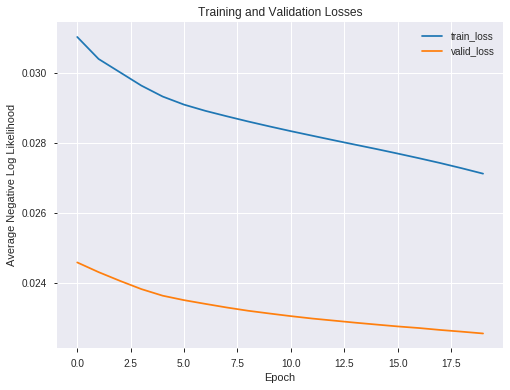

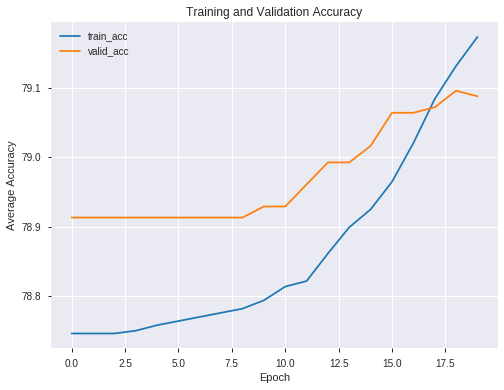

In [43]:

plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')


## Confusion Matrix

F1: 0.0


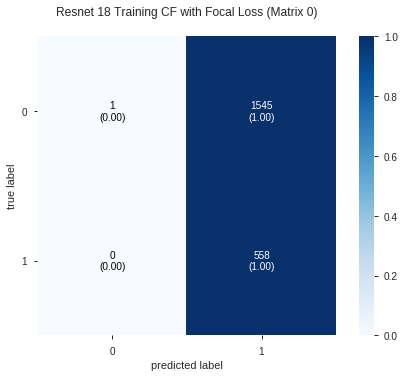

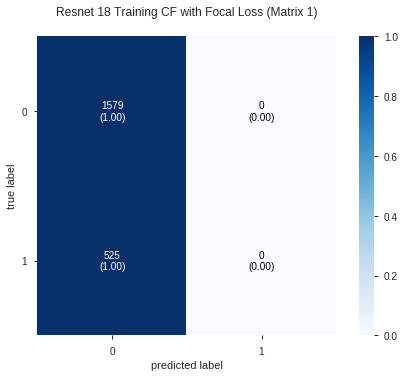

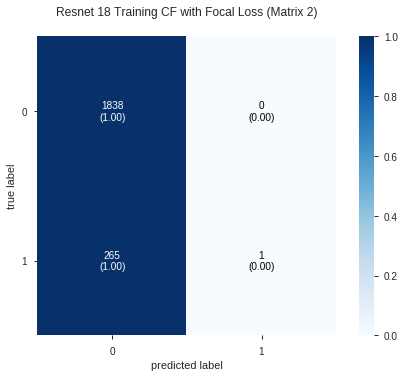

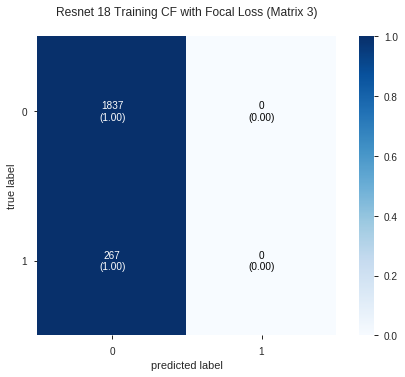

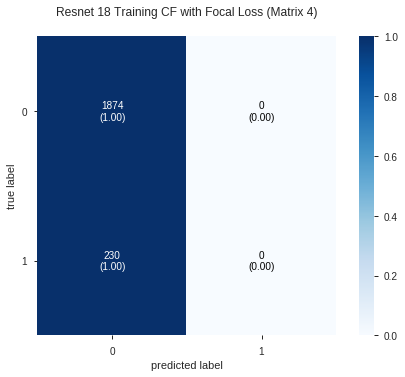

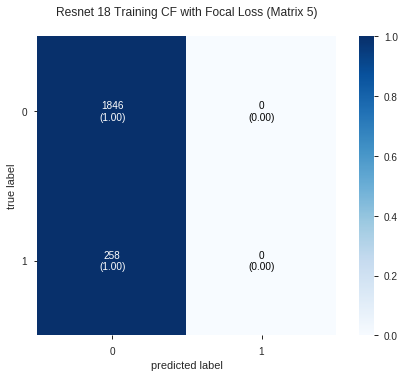

In [45]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.metrics import multilabel_confusion_matrix
from mlxtend.plotting import plot_confusion_matrix


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
pr =[]
tl =[]
    
with torch.no_grad():
    for images, labels in iter(valid_loader):
        images = images.to(device)
        labels = labels.to(device)
        images = images.permute(0,3,2,1)
        hot_labels = encoder(labels, 6)
        hot_labels = hot_labels.to(device)
        outputs = model(images)
        outputs[outputs >= 0.5] = 1
        outputs[outputs < 0.5] = 0
        
        for i in hot_labels.tolist():
            tl.append(i)
        for j in outputs.tolist():
            pr.append(j)

    pr = np.argmax(pr, axis=1)
    tl = np.argmax(tl, axis=1)

cm = multilabel_confusion_matrix(np.array(tl),np.array(pr))
labels=['0','1','2','3','4','5']
fig, ax = plot_confusion_matrix(conf_mat=cm[0], show_absolute=True, show_normed=True, colorbar=True)
plt.title('Resnet 18 Training CF with Focal Loss (Matrix 0)')

fig, ax = plot_confusion_matrix(conf_mat=cm[1], show_absolute=True, show_normed=True, colorbar=True)
plt.title('Resnet 18 Training CF with Focal Loss (Matrix 1)')

fig, ax = plot_confusion_matrix(conf_mat=cm[2], show_absolute=True, show_normed=True, colorbar=True)
plt.title('Resnet 18 Training CF with Focal Loss (Matrix 2)')

fig, ax = plot_confusion_matrix(conf_mat=cm[3], show_absolute=True, show_normed=True, colorbar=True)
plt.title('Resnet 18 Training CF with Focal Loss (Matrix 3)')

fig, ax = plot_confusion_matrix(conf_mat=cm[4], show_absolute=True, show_normed=True, colorbar=True)
plt.title('Resnet 18 Training CF with Focal Loss (Matrix 4)')

fig, ax = plot_confusion_matrix(conf_mat=cm[5], show_absolute=True, show_normed=True, colorbar=True)
plt.title('Resnet 18 Training CF with Focal Loss (Matrix 5)')

print('F1: {}'.format(f1_score(hot_labels.data.cpu().numpy(), outputs.data.cpu().numpy(), average='macro')))

## Loading VGG16 Model

In [ ]:
vgg16 = models.vgg16(pretrained=False).to(device)
vgg16.classifier = nn.Sequential(
               nn.Linear(25088, 770),
               nn.ReLU(inplace=True),
               nn.Linear(770, 770),
               nn.ReLU(inplace=True),
               nn.Linear(770, 6)).to(device)

for param in vgg16.parameters():
    param.requires_grad = True

In [ ]:
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.8)
model, history = train(vgg16, train_loader, valid_loader, 50)

## loss and Accuracy Curve

In [ ]:

plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')


## Confusion Matrix


In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.metrics import multilabel_confusion_matrix
from mlxtend.plotting import plot_confusion_matrix


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
pr =[]
tl =[]
    
with torch.no_grad():
    for images, labels in iter(valid_loader):
        images = images.to(device)
        labels = labels.to(device)
        images = images.permute(0,3,2,1)
        hot_labels = encoder(labels, 6)
        hot_labels = hot_labels.to(device)
        outputs = model(images)
        outputs[outputs >= 0.5] = 1
        outputs[outputs < 0.5] = 0
        
        for i in hot_labels.tolist():
            tl.append(i)
        for j in outputs.tolist():
            pr.append(j)

    pr = np.argmax(pr, axis=1)
    tl = np.argmax(tl, axis=1)
        
cm = multilabel_confusion_matrix(np.array(tl),np.array(pr))
labels=['0','1','2','3','4','5']
fig, ax = plot_confusion_matrix(conf_mat=cm[0], show_absolute=True, show_normed=True, colorbar=True)
plt.title('vgg16 Training CF with Focal Loss (Matrix 0)')

fig, ax = plot_confusion_matrix(conf_mat=cm[1], show_absolute=True, show_normed=True, colorbar=True)
plt.title('vgg16 Training CF with Focal Loss (Matrix 1)')

fig, ax = plot_confusion_matrix(conf_mat=cm[2], show_absolute=True, show_normed=True, colorbar=True)
plt.title('vgg16 Training CF with Focal Loss (Matrix 2)')

fig, ax = plot_confusion_matrix(conf_mat=cm[3], show_absolute=True, show_normed=True, colorbar=True)
plt.title('vgg16 Training CF with Focal Loss (Matrix 3)')

fig, ax = plot_confusion_matrix(conf_mat=cm[4], show_absolute=True, show_normed=True, colorbar=True)
plt.title('vgg16 Training CF with Focal Loss (Matrix 4)')

fig, ax = plot_confusion_matrix(conf_mat=cm[5], show_absolute=True, show_normed=True, colorbar=True)
plt.title('vgg16 Training CF with Focal Loss (Matrix 5)')

print('F1: {}'.format(f1_score(hot_labels.data.cpu().numpy(), outputs.data.cpu().numpy(), average='macro')))